In [1]:
import sandbox_fm.depth
import sandbox_fm.sandbox_fm
import sandbox_fm.calibrate
import bmi.wrapper
import pathlib
import matplotlib.pyplot as plt
import sandbox_fm.plots
import numpy as np
import scipy.stats
import matplotlib.collections
import json
import cv2


%matplotlib inline

In [2]:
with open('../config.json') as f:
    config = json.load(f)
images = sandbox_fm.depth.calibrated_depth_images()

In [3]:
img_0 = next(images)


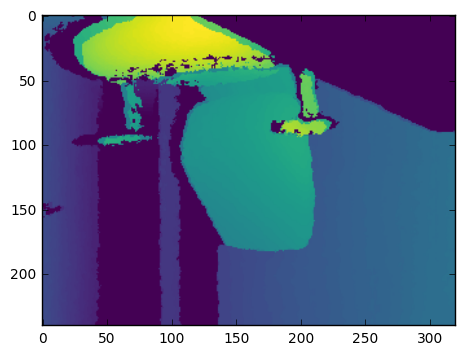

In [4]:
plt.imshow(img_0, cmap='viridis')

In [5]:
img = next(images)

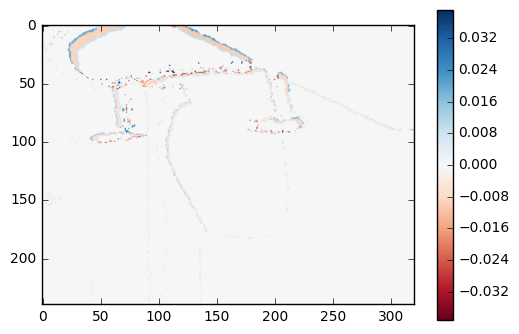

In [6]:
vmax = (img - img_0).max()
vmin = -vmax
plt.imshow(img - img_0, matplotlib.cm.RdBu, vmin=vmin, vmax=vmax)
plt.colorbar()

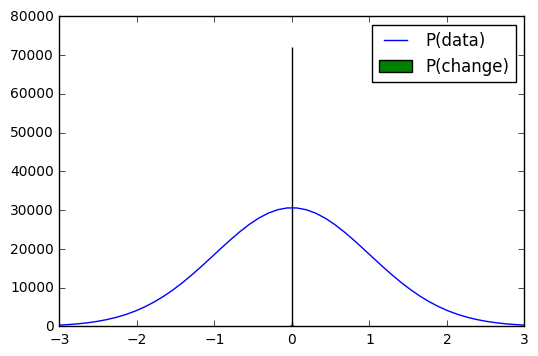

In [7]:
# let's use a normal probability distribution to compute the likelyhood of a change. This is our prior.
# This is our P(change)  in P(change|data) = P(data|change)P(change)/P(data)
# 
P = scipy.stats.norm(0.0, 1.0)
x = np.linspace(-3, 3)
plt.plot(x, P.pdf(x)*len(img.ravel()), label='P(data)')
_ = plt.hist(img.ravel() - img_0.ravel(), bins=100, label='P(change)')
plt.legend()

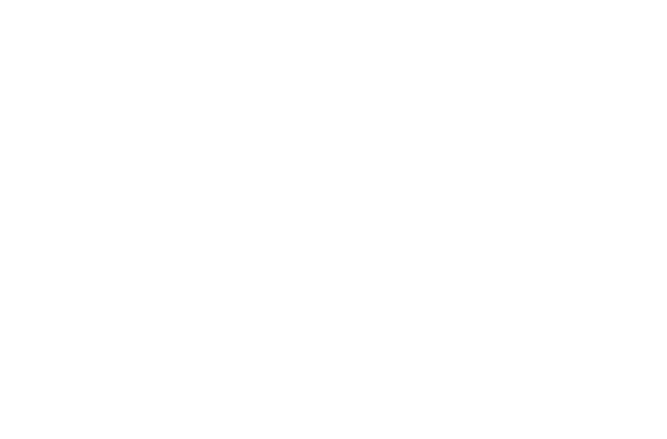

In [8]:
vis = sandbox_fm.plots.Visualization()

In [9]:

model = bmi.wrapper.BMIWrapper('dflowfm')
img = next(images)
data = dict(
    kinect_0=img.copy(),
    kinect=img
)


In [10]:
model.get_current_time()

0.0

In [11]:
path = pathlib.Path('../tests/FM_zandbak_update_PV_v1/zm_v2.mdu')
# make sure to pass absolute path
model.initialize(str(path.absolute()))

In [12]:
sandbox_fm.sandbox_fm.update_delft3d_initial_vars(data, model)


In [13]:
data['zk']

array([-11.47    , -11.545   , -11.57    , ...,  10.247865,  11.583674,
        15.764081])

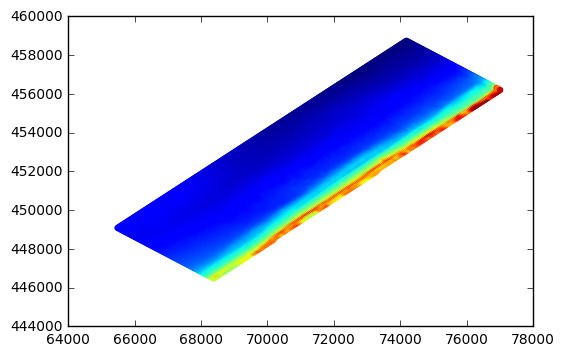

In [14]:
plt.scatter(data['xk'], data['yk'], c=data['zk'], edgecolor='none')

In [15]:
sandbox_fm.sandbox_fm.update_delft3d_vars(data, model)


(450000, 450500)

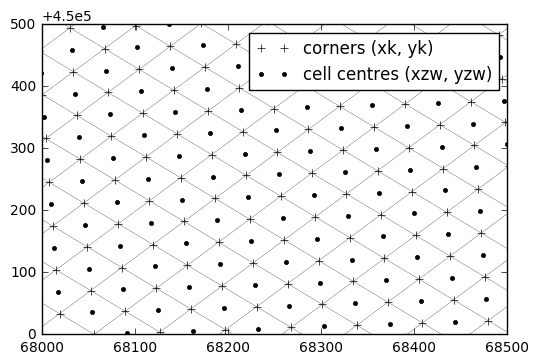

In [16]:
fig, ax = plt.subplots()
ax.plot(data['xk'], data['yk'], 'k+', label='corners (xk, yk)')
ax.plot(data['xzw'], data['yzw'], 'k.', label='cell centres (xzw, yzw)')
xcc = data['xk'][data['flowelemnode']-1]
ycc = data['yk'][data['flowelemnode']-1]
polys = matplotlib.collections.PolyCollection(np.dstack([xcc, ycc]), facecolor='none', linewidth=0.1)
ax.add_collection(polys)
plt.legend()
plt.xlim(68000, 68500)
plt.ylim(450000, 450500)

In [17]:
    # coordinates of the image in the model
img_in_model = np.array(config['bbox'], dtype='float32')


In [18]:
img_in_model

array([[  71000.       ,  449500.       ],
       [  74442.0859375,  453660.78125  ],
       [  71668.2421875,  455955.5      ],
       [  68226.1484375,  451794.71875  ]], dtype=float32)

In [19]:

img2model, model2img = sandbox_fm.calibrate.compute_affines(img_in_model, img.shape)


In [20]:

# create xy1 matrices for model and img
xy_cells_model = np.c_[
    data['xzw'],
    data['yzw'],
    np.ones_like(data['xzw'])
]
xy_corners_model = np.c_[
    data['xk'],
    data['yk'],
    np.ones_like(data['xk'])
]

img_in_model_path = matplotlib.path.Path(img_in_model)

cells_in_sandbox = img_in_model_path.contains_points(xy_cells_model[:, :2])
data['cells_in_sandbox'] = cells_in_sandbox

Y_img, X_img = np.mgrid[:img.shape[0], :img.shape[1]]
xy_img = np.c_[X_img.ravel(), Y_img.ravel(), np.ones_like(X_img.ravel())]
data['xy_img'] = xy_img

# image in model coordinates
data['xy_img_in_model'] = np.dot(xy_img, img2model.T)
# multiply [x, y, 1] with affine' gives [xt, yt, 1] (B'A' = (AB)')
data['xy_cells_model_in_img'] = np.dot(xy_cells_model, model2img.T)
data['xy_corners_model_in_img'] = np.dot(xy_corners_model, model2img.T)



In [21]:
vis.initialize(data)

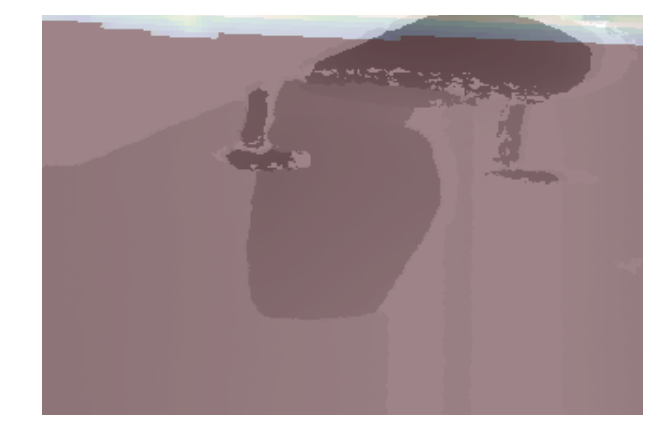

In [22]:
vis.fig

In [23]:
img_in_img = np.array([
    [0, 0],
    [0, img.shape[0]],
    [img.shape[1], img.shape[0]],
    [img.shape[1], 0]
    
], dtype='float32')
img2model = cv2.getPerspectiveTransform(img_in_img, img_in_model)
model2img = cv2.getPerspectiveTransform(img_in_model, img_in_img)

In [24]:
X_model, Y_model = cv2.perspectiveTransform(np.dstack([X_img, Y_img]).astype('float32'), img2model).T


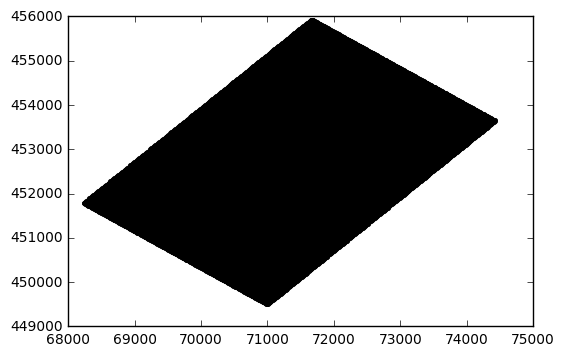

In [25]:
plt.plot(X_model.ravel(), Y_model.ravel(), 'k.')

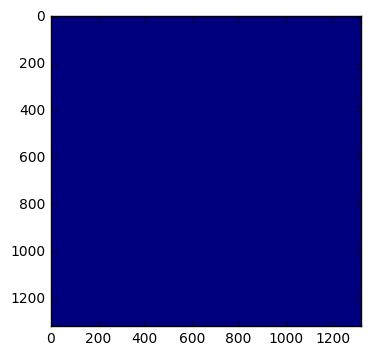

In [26]:
plt.imshow(cv2.warpPerspective(img, img2model, (1320, 1320)))

In [27]:
xy_cells_model_in_img = np.squeeze(
    cv2.perspectiveTransform(
        np.dstack([
            xy_cells_model[:,np.newaxis,0], 
            xy_cells_model[:,np.newaxis,1]
        ]).astype('float32'), 
        model2img
    )
)
xy_corners_model_in_img = np.squeeze(
    cv2.perspectiveTransform(
        np.dstack([
            xy_corners_model[:,np.newaxis,0], 
            xy_corners_model[:,np.newaxis,1]
        ]).astype('float32'), 
        model2img
    )
)
                             

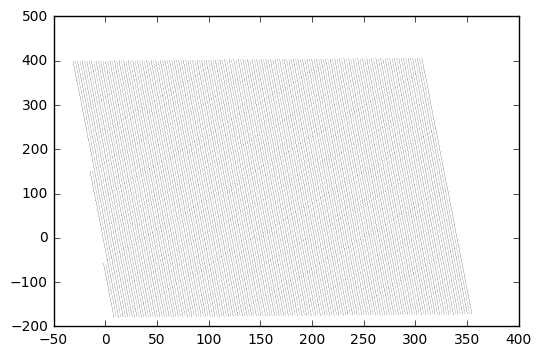

In [28]:
plt.plot(xy_cells_model_in_img[:,0], xy_cells_model_in_img[:,1], 'k.', markersize=0.1)
plt.plot(xy_corners_model_in_img[:,0], xy_corners_model_in_img[:,1], 'k+', markersize=0.1)